# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import torchvision.models as models


import torch
import torchaudio
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Ensure CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Crema Dataset

In [ ]:
Crema_df = pd.read_csv('/content/drive/My Drive/deep_learn_project/Crema_df.csv')
Crema_df.head().style.set_properties(**{'background-color': '#9490ff','color': 'black', 'border-color': 'black'})

,Emotions,Path
0,neutral,/content/drive/My Drive/deep_learn_project/AudioWAV/1079_TSI_NEU_XX.wav
1,happy,/content/drive/My Drive/deep_learn_project/AudioWAV/1079_WSI_HAP_XX.wav
2,fear,/content/drive/My Drive/deep_learn_project/AudioWAV/1079_TSI_FEA_XX.wav
3,fear,/content/drive/My Drive/deep_learn_project/AudioWAV/1080_DFA_FEA_XX.wav
4,fear,/content/drive/My Drive/deep_learn_project/AudioWAV/1079_TIE_FEA_XX.wav


# Compute Spectrograms (pre-proccessing)

In [ ]:
def spectrogram(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    mel_spectrogram = MelSpectrogram(sample_rate=sample_rate, n_mels=128)(waveform.squeeze())
    mel_spectrogram_db = AmplitudeToDB()(mel_spectrogram)
    return mel_spectrogram_db

tqdm.pandas()  # Initializes tqdm for pandas
Crema_df['Spectrogram'] = Crema_df['Path'].progress_apply(spectrogram)

  0%|          | 0/7442 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
100%|██████████| 7442/7442 [42:38<00:00,  2.91it/s]


In [ ]:
Crema_df.to_pickle('/content/drive/My Drive/deep_learn_project/Crema_spect_df.pkl')

In [ ]:
Crema_df = pd.read_pickle('/content/drive/My Drive/deep_learn_project/Crema_spect_df.pkl')

# Define Dataset class
(resize to constant length)

In [ ]:
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn.functional as F

class CremaDataset(Dataset):
    def __init__(self, df, transform=None, target_size=(128, 256)):
        self.df = df
        self.transform = transform
        self.label_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
        self.target_size = target_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        spectrogram = self.df.iloc[idx, 2]  # Assuming spectrogram is in the 3rd column
        label = self.df.iloc[idx, 0]
        label = self.label_map[label]

        # Resize spectrogram to target size (pad or trim)
        if spectrogram.size(0) < self.target_size[0]:
            # Pad to target size
            pad_size = (0, self.target_size[1] - spectrogram.size(1))
            spectrogram = F.pad(spectrogram, pad_size, mode='constant', value=0)
        elif spectrogram.size(0) > self.target_size[0]:
            # Trim to target size
            spectrogram = spectrogram[:self.target_size[0], :self.target_size[1]]
        else:
            # If width is shorter, pad width
            if spectrogram.size(1) < self.target_size[1]:
                pad_size = (0, self.target_size[1] - spectrogram.size(1))
                spectrogram = F.pad(spectrogram, pad_size, mode='constant', value=0)
            elif spectrogram.size(1) > self.target_size[1]:
                # Trim to target size
                spectrogram = spectrogram[:, :self.target_size[1]]

        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

# Define Metrics

In [ ]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode, turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images.unsqueeze(1))
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    model_accuracy = total_correct / total_images * 100
    return model_accuracy

# Split to train and test

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and test sets
train_df, test_df = train_test_split(Crema_df, test_size=0.2, stratify=Crema_df['Emotions'], random_state=42)

# Create train and test datasets
train_dataset = CremaDataset(train_df)
test_dataset = CremaDataset(test_df)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Define model and modify first and last layers

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept single-channel (spectrogram) input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=(2, 2), padding=(3, 3), bias=False)

# Modify the fully connected layer to output the number of emotion classes
model.fc = nn.Linear(model.fc.in_features, 6)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


# Training loop and plot results - without augmentations

Epoch 1/10: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]


Epoch: 1 | Loss: 1.3301 | Training accuracy: 61.162% | Test accuracy: 52.653% | Epoch Time: 17.45 secs


Epoch 2/10: 100%|██████████| 47/47 [00:10<00:00,  4.37it/s]


Epoch: 2 | Loss: 0.8869 | Training accuracy: 78.313% | Test accuracy: 56.548% | Epoch Time: 15.57 secs


Epoch 3/10: 100%|██████████| 47/47 [00:10<00:00,  4.33it/s]


Epoch: 3 | Loss: 0.5364 | Training accuracy: 93.885% | Test accuracy: 58.026% | Epoch Time: 15.71 secs


Epoch 4/10: 100%|██████████| 47/47 [00:11<00:00,  4.26it/s]


Epoch: 4 | Loss: 0.2555 | Training accuracy: 99.026% | Test accuracy: 58.160% | Epoch Time: 15.95 secs


Epoch 5/10: 100%|██████████| 47/47 [00:11<00:00,  4.19it/s]


Epoch: 5 | Loss: 0.1002 | Training accuracy: 99.933% | Test accuracy: 58.630% | Epoch Time: 16.31 secs


Epoch 6/10: 100%|██████████| 47/47 [00:11<00:00,  4.08it/s]


Epoch: 6 | Loss: 0.0443 | Training accuracy: 99.983% | Test accuracy: 59.637% | Epoch Time: 16.87 secs


Epoch 7/10: 100%|██████████| 47/47 [00:11<00:00,  3.98it/s]


Epoch: 7 | Loss: 0.0265 | Training accuracy: 100.000% | Test accuracy: 58.831% | Epoch Time: 17.43 secs


Epoch 8/10: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s]


Epoch: 8 | Loss: 0.0194 | Training accuracy: 100.000% | Test accuracy: 59.436% | Epoch Time: 17.73 secs


Epoch 9/10: 100%|██████████| 47/47 [00:11<00:00,  4.04it/s]


Epoch: 9 | Loss: 0.0146 | Training accuracy: 100.000% | Test accuracy: 59.436% | Epoch Time: 17.27 secs


Epoch 10/10: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


Epoch: 10 | Loss: 0.0125 | Training accuracy: 100.000% | Test accuracy: 58.899% | Epoch Time: 17.18 secs
==> Finished Training ...


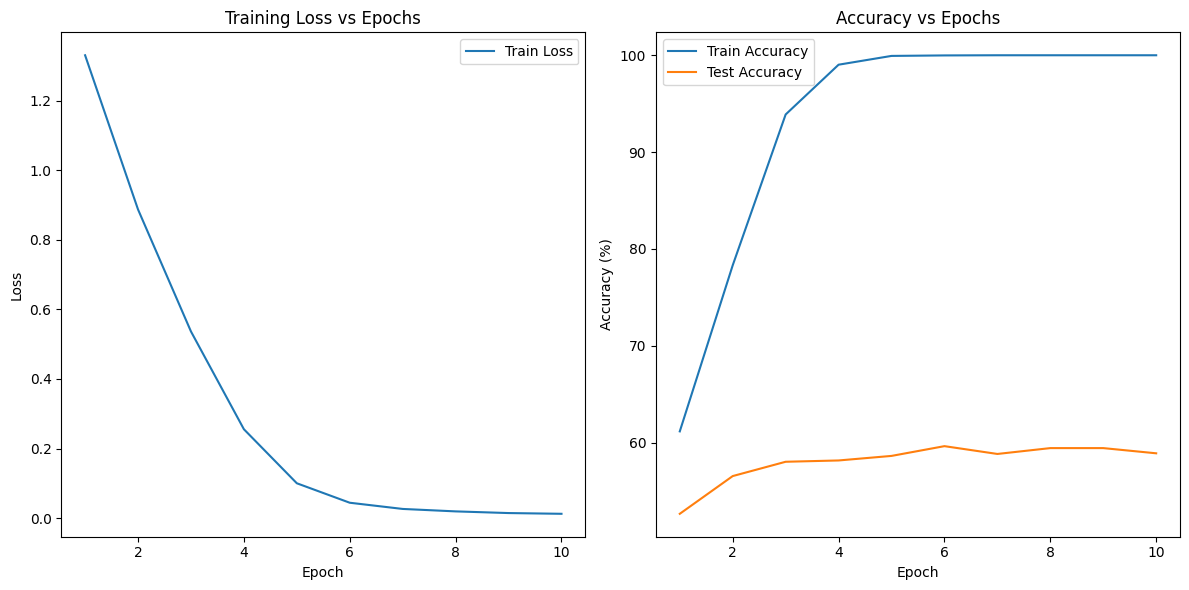

In [ ]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize variables for history
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_accuracy': []
}

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    epoch_time = time.time()

    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}'), 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.data.item()

    # Normalize loss by the number of training batches
    running_loss /= len(train_loader)

    scheduler.step()

    # Calculate training and test accuracy
    train_accuracy = calculate_accuracy(model, train_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    # Save history
    history['train_loss'].append(running_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

    # Log information
    log = f"Epoch: {epoch} | Loss: {running_loss:.4f} | Training accuracy: {train_accuracy:.3f}% | Test accuracy: {test_accuracy:.3f}% | "
    epoch_time = time.time() - epoch_time
    log += f"Epoch Time: {epoch_time:.2f} secs"
    print(log)

print('==> Finished Training ...')

# Plot the loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history['train_accuracy'], label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), history['test_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

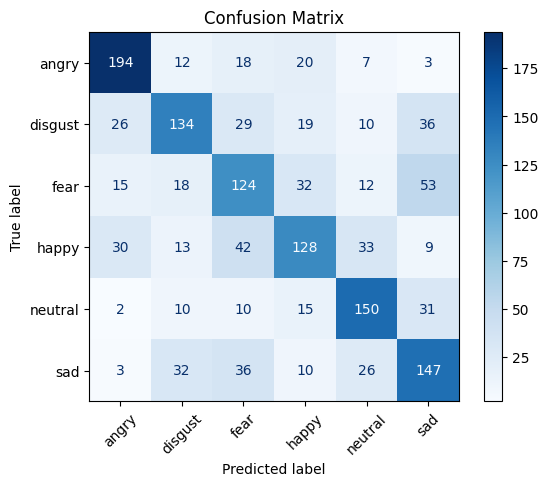

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get model predictions and true labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs.unsqueeze(1))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 2: Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Step 3: Plot the confusion matrix
labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()


# Define augmentations

In [ ]:
import torchaudio.transforms as T

# Augmentation functions
def add_noise(waveform, noise_level=0.01):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise

def change_vol(waveform):
    tranform = T.Vol(gain=5.0)
    return tranform(waveform)

def time_masking(waveform, mask_length=2000):
    n_samples = waveform.shape[1]
    # Ensure the mask length is not longer than the waveform
    if mask_length >= n_samples:
        raise ValueError("Mask length must be smaller than the number of samples in the waveform")
    # Randomly choose the start position for the mask
    start = torch.randint(0, n_samples - mask_length, (1,)).item()
    # Apply the mask
    waveform[:, start:start + mask_length] = 0.0
    return waveform

# Apply augmentations on train audio files and calculate spectrograms for it

In [ ]:
# Spectrogram function
def spectrogram(waveform, sample_rate):
    mel_spectrogram = MelSpectrogram(sample_rate=sample_rate, n_mels=128)(waveform)
    mel_spectrogram_db = AmplitudeToDB()(mel_spectrogram)
    return mel_spectrogram_db

# List to store the augmented data
augmented_train_data = []

# Loop through each row in the original DataFrame
for index, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Processing Audio Files"):
    emotion = row['Emotions']
    file_path = row['Path']

    # Load the original audio
    waveform, sample_rate = torchaudio.load(file_path)

    # Apply augmentations
    augmented_waveforms = {
        'add_noise': add_noise(waveform),
        'change_vol': change_vol(waveform),
        'time_masking': time_masking(waveform)
    }

    # Generate and store spectrograms for each augmented audio
    for aug_name, aug_waveform in augmented_waveforms.items():
        spect = spectrogram(aug_waveform, sample_rate).squeeze()
        augmented_train_data.append({
            'Emotions': emotion,
            'Original Path': file_path,
            'Spectrogram': spect,
            'Augmentation': aug_name
        })

# Create a new DataFrame with the augmented data
augmented_df = pd.DataFrame(augmented_train_data)

# Save the DataFrame to a pickle file for future use
augmented_df.to_pickle('/content/drive/My Drive/deep_learn_project/augmented_train_df.pkl')

In [ ]:
augmented_df = pd.read_pickle('/content/drive/My Drive/deep_learn_project/augmented_train_df.pkl')

# Combine non augmented and augmented datasets

In [ ]:
from torch.utils.data import ConcatDataset

# Create Augmented dataset
aug_dataset = CremaDataset(augmented_df)

# Combine train sets
combined_train_dataset = ConcatDataset([train_dataset, aug_dataset])

# Create combined train loader
combined_train_loader = DataLoader(combined_train_dataset, batch_size=128, shuffle=True, num_workers=2)

# Redefine model

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept single-channel (spectrogram) input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=(2, 2), padding=(3, 3), bias=False)

# Modify the fully connected layer to output the number of emotion classes
model.fc = nn.Linear(model.fc.in_features, 6)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training loop and plot results - with augmentations

Epoch 1/10: 100%|██████████| 187/187 [00:47<00:00,  3.94it/s]


Epoch: 1 | Loss: 4.8149 | Training accuracy: 71.393% | Test accuracy: 58.361% | Epoch Time: 53.57 secs


Epoch 2/10: 100%|██████████| 187/187 [00:45<00:00,  4.09it/s]


Epoch: 2 | Loss: 2.8805 | Training accuracy: 86.813% | Test accuracy: 59.167% | Epoch Time: 51.19 secs


Epoch 3/10: 100%|██████████| 187/187 [00:46<00:00,  4.03it/s]


Epoch: 3 | Loss: 1.4522 | Training accuracy: 98.975% | Test accuracy: 61.115% | Epoch Time: 51.71 secs


Epoch 4/10: 100%|██████████| 187/187 [00:46<00:00,  4.05it/s]


Epoch: 4 | Loss: 0.7743 | Training accuracy: 99.479% | Test accuracy: 59.637% | Epoch Time: 52.02 secs


Epoch 5/10: 100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


Epoch: 5 | Loss: 0.4755 | Training accuracy: 100.000% | Test accuracy: 62.055% | Epoch Time: 52.67 secs


Epoch 6/10: 100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


Epoch: 6 | Loss: 0.1690 | Training accuracy: 100.000% | Test accuracy: 59.302% | Epoch Time: 52.16 secs


Epoch 7/10: 100%|██████████| 187/187 [00:46<00:00,  4.06it/s]


Epoch: 7 | Loss: 0.1476 | Training accuracy: 100.000% | Test accuracy: 62.928% | Epoch Time: 51.44 secs


Epoch 8/10: 100%|██████████| 187/187 [00:45<00:00,  4.07it/s]


Epoch: 8 | Loss: 0.1253 | Training accuracy: 100.000% | Test accuracy: 61.786% | Epoch Time: 51.75 secs


Epoch 9/10: 100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


Epoch: 9 | Loss: 0.1153 | Training accuracy: 99.983% | Test accuracy: 62.458% | Epoch Time: 53.20 secs


Epoch 10/10: 100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


Epoch: 10 | Loss: 0.0458 | Training accuracy: 99.983% | Test accuracy: 61.451% | Epoch Time: 51.65 secs
==> Finished Training ...


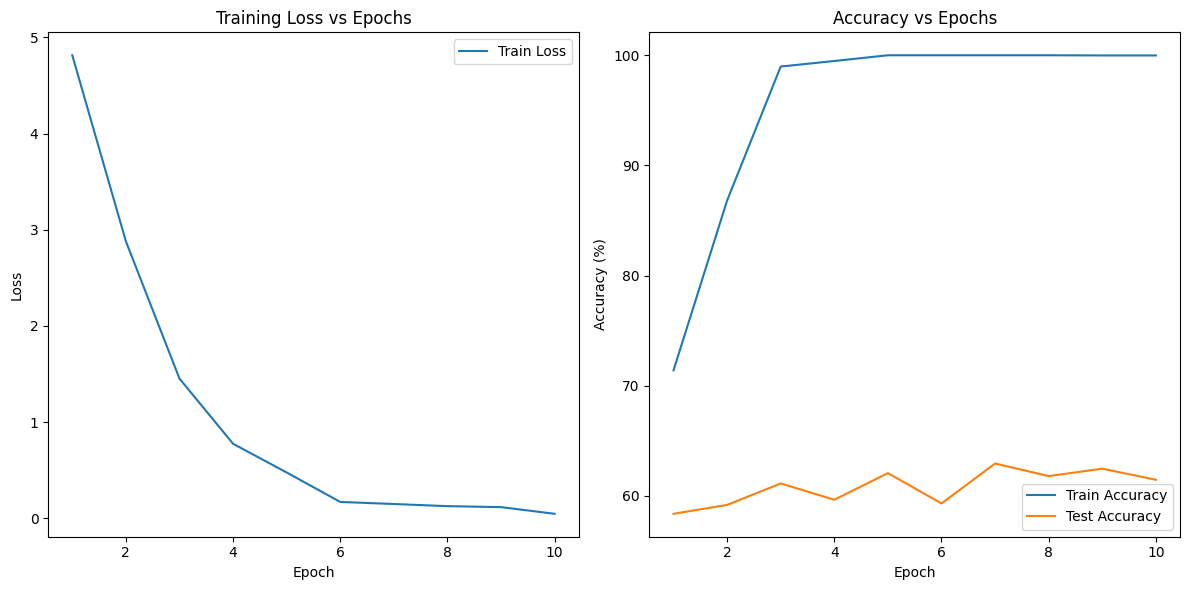

In [ ]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize variables for history
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_accuracy': []
}

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    epoch_time = time.time()

    for i, data in enumerate(tqdm(combined_train_loader, desc=f'Epoch {epoch}/{num_epochs}'), 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.data.item()

    # Normalize loss by the number of training batches
    running_loss /= len(train_loader)

    scheduler.step()

    # Calculate training and test accuracy
    train_accuracy = calculate_accuracy(model, train_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    # Save history
    history['train_loss'].append(running_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

    # Log information
    log = f"Epoch: {epoch} | Loss: {running_loss:.4f} | Training accuracy: {train_accuracy:.3f}% | Test accuracy: {test_accuracy:.3f}% | "
    epoch_time = time.time() - epoch_time
    log += f"Epoch Time: {epoch_time:.2f} secs"
    print(log)

print('==> Finished Training ...')

# Plot the loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history['train_accuracy'], label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), history['test_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

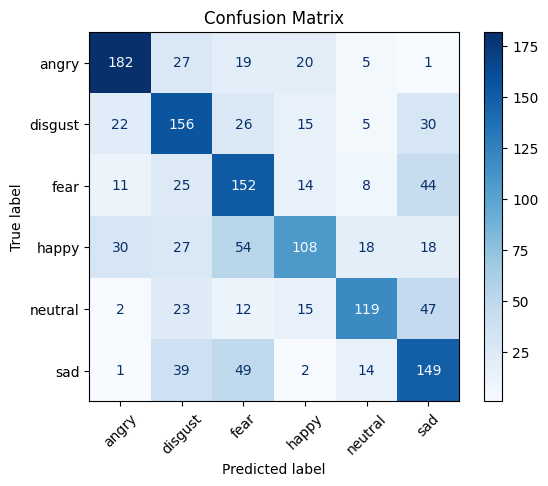

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get model predictions and true labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs.unsqueeze(1))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 2: Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Step 3: Plot the confusion matrix
labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Define modified model - to reduce overfit

In [ ]:
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedResNet18, self).__init__()
        # Load the pre-trained ResNet18 model
        self.resnet = models.resnet18(pretrained=True)

        # Modify the first convolutional layer to accept single-channel input
        self.resnet.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5)  # Dropout after ReLU
        )

        # Replace the fully connected layer with a new one with dropout
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout
            nn.Linear(self.resnet.fc.in_features, 6)
        )

    def forward(self, x):
        return self.resnet(x)

mod_model = ModifiedResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mod_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)

# Train modified model and plot results

Epoch 1/15: 100%|██████████| 187/187 [00:49<00:00,  3.79it/s]


Epoch: 1 | Loss: 6.8189 | Training accuracy: 43.100% | Test accuracy: 41.974% | Epoch Time: 67.32 secs


Epoch 2/15: 100%|██████████| 187/187 [00:49<00:00,  3.79it/s]


Epoch: 2 | Loss: 5.8687 | Training accuracy: 49.992% | Test accuracy: 49.698% | Epoch Time: 67.35 secs


Epoch 3/15: 100%|██████████| 187/187 [00:49<00:00,  3.78it/s]


Epoch: 3 | Loss: 5.3493 | Training accuracy: 54.191% | Test accuracy: 51.242% | Epoch Time: 68.23 secs


Epoch 4/15: 100%|██████████| 187/187 [00:49<00:00,  3.78it/s]


Epoch: 4 | Loss: 4.9059 | Training accuracy: 58.571% | Test accuracy: 53.929% | Epoch Time: 67.66 secs


Epoch 5/15: 100%|██████████| 187/187 [00:49<00:00,  3.80it/s]


Epoch: 5 | Loss: 4.5504 | Training accuracy: 64.715% | Test accuracy: 57.085% | Epoch Time: 67.17 secs


Epoch 6/15: 100%|██████████| 187/187 [00:49<00:00,  3.78it/s]


Epoch: 6 | Loss: 4.1704 | Training accuracy: 68.079% | Test accuracy: 58.428% | Epoch Time: 68.20 secs


Epoch 7/15: 100%|██████████| 187/187 [00:49<00:00,  3.78it/s]


Epoch: 7 | Loss: 3.7617 | Training accuracy: 71.241% | Test accuracy: 59.772% | Epoch Time: 68.37 secs


Epoch 8/15: 100%|██████████| 187/187 [00:49<00:00,  3.78it/s]


Epoch: 8 | Loss: 3.4209 | Training accuracy: 75.790% | Test accuracy: 60.175% | Epoch Time: 67.61 secs


Epoch 9/15: 100%|██████████| 187/187 [00:49<00:00,  3.79it/s]


Epoch: 9 | Loss: 3.0226 | Training accuracy: 79.918% | Test accuracy: 60.443% | Epoch Time: 67.49 secs


Epoch 10/15: 100%|██████████| 187/187 [00:49<00:00,  3.79it/s]


Epoch: 10 | Loss: 2.6759 | Training accuracy: 81.971% | Test accuracy: 58.966% | Epoch Time: 67.75 secs


Epoch 11/15: 100%|██████████| 187/187 [00:49<00:00,  3.76it/s]


Epoch: 11 | Loss: 2.3823 | Training accuracy: 86.318% | Test accuracy: 59.704% | Epoch Time: 68.60 secs


Epoch 12/15: 100%|██████████| 187/187 [00:49<00:00,  3.79it/s]


Epoch: 12 | Loss: 2.1118 | Training accuracy: 87.842% | Test accuracy: 59.167% | Epoch Time: 67.18 secs


Epoch 13/15: 100%|██████████| 187/187 [00:49<00:00,  3.79it/s]


Epoch: 13 | Loss: 1.8514 | Training accuracy: 90.694% | Test accuracy: 60.578% | Epoch Time: 67.45 secs


Epoch 14/15: 100%|██████████| 187/187 [00:49<00:00,  3.79it/s]


Epoch: 14 | Loss: 1.6975 | Training accuracy: 91.609% | Test accuracy: 59.570% | Epoch Time: 67.35 secs


Epoch 15/15: 100%|██████████| 187/187 [00:49<00:00,  3.78it/s]


Epoch: 15 | Loss: 1.5414 | Training accuracy: 92.222% | Test accuracy: 59.234% | Epoch Time: 68.15 secs
==> Finished Training ...


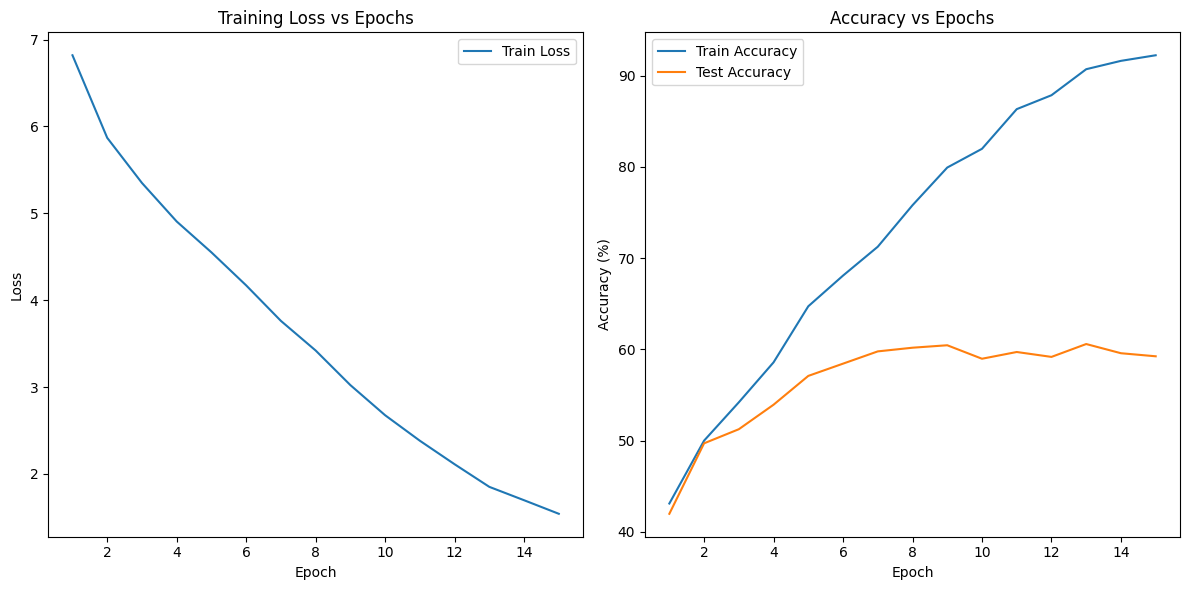

In [ ]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize variables for history
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_accuracy': []
}

num_epochs = 15

for epoch in range(1, num_epochs + 1):
    mod_model.train()
    running_loss = 0.0
    epoch_time = time.time()

    for i, data in enumerate(tqdm(combined_train_loader, desc=f'Epoch {epoch}/{num_epochs}'), 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = mod_model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.data.item()

    # Normalize loss by the number of training batches
    running_loss /= len(train_loader)

    scheduler.step()

    # Calculate training and test accuracy
    train_accuracy = calculate_accuracy(mod_model, combined_train_loader, device)
    test_accuracy = calculate_accuracy(mod_model, test_loader, device)

    # Save history
    history['train_loss'].append(running_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

    # Log information
    log = f"Epoch: {epoch} | Loss: {running_loss:.4f} | Training accuracy: {train_accuracy:.3f}% | Test accuracy: {test_accuracy:.3f}% | "
    epoch_time = time.time() - epoch_time
    log += f"Epoch Time: {epoch_time:.2f} secs"
    print(log)

print('==> Finished Training ...')

# Plot the loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history['train_accuracy'], label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), history['test_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

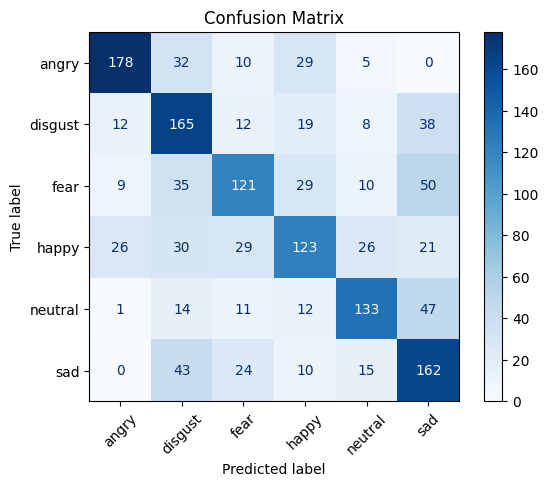

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get model predictions and true labels
mod_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mod_model(inputs.unsqueeze(1))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 2: Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Step 3: Plot the confusion matrix
labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()